In [12]:
import numpy as np

import matplotlib.pyplot as plt

import time

from poliastro.bodies import Earth
from poliastro.twobody import Orbit
from poliastro.util import norm
from poliastro.constants import R_earth
from poliastro.core.elements import coe2rv
from poliastro.twobody.sampling import EpochsArray
from poliastro.twobody.propagation import CowellPropagator

from astropy import units as u
from astropy.time import Time, TimeDelta

from datetime import datetime, timedelta
from sso_inc import inc_from_alt, raan_from_ltan,angle_between

from perturbations import perturbations_coesa_J2_low, perturbations_coesa_J2_high

from osc2mean_dd import osc2mean


toc = time.time()
## Orbit
h = 300
start_date = datetime(2024,1,1,9,0,0)
ltan = 22.5

a = (R_earth.value/1000 + h) << u.km
ecc = 1e-6 << u.one
inc = inc_from_alt(h,ecc)[0] << u.deg   
raan = raan_from_ltan(Time(val=datetime.timestamp(start_date), format='unix'),ltan) << u.deg
argp = 1e-6 << u.deg
nu = 1e-6 << u.deg

epoch = Time(val=start_date.isoformat(), format='isot')

delta_a = 1
delta_nu = 0

reference_orbit = Orbit.from_classical(
    Earth,
    a,
    ecc,
    inc,
    raan,
    argp,
    nu,
    epoch
    )
trailing_orbit = Orbit.from_classical(
    Earth,
    (a.value+delta_a)<<u.km,
    ecc,
    inc,
    raan,
    argp,
    (nu.value+delta_nu)<<u.deg,
    epoch
    )

# def nu2ma(ecc, nu):
#     ecc_anomaly = np.arccos((ecc + np.cos(nu))/(1 + ecc*np.cos(nu)))
#     ma = ecc_anomaly - ecc*np.sin(ecc_anomaly)
#     return ma    


time_step = 3600<<u.s
assignment = 50%360
end_time = 60*60*24*50
pred_days = 5

refsmalist = []
refsmalist_mean = []
trailsmalist = []
trailsmalist_mean = []



ref_vel = []
trail_vel = []

elapsedsecs = []
secs = 0

rmag_ref = []
rmag_trail = []

vmag_ref = []
vmag_trail = []

angle_list = []
ang_vel_list = []

theta_err_list = []

mean_ang_list = []

#for timestamp in range(len(timestamps)):
start_date_prop = epoch
ref_mean = osc2mean(a.value, ecc.value, inc.value, raan.value, argp.value, nu.value)
ref_mean_orbit = Orbit.from_classical(Earth, ref_mean[0]<<u.km, ref_mean[1]<<u.one, ref_mean[2]<<u.deg, ref_mean[3]<<u.deg, ref_mean[4]<<u.deg, nu, epoch)
trail_mean = osc2mean(a.value+delta_a, ecc.value, inc.value, raan.value, argp.value, nu.value+delta_nu)
trail_mean_orbit = Orbit.from_classical(Earth, trail_mean[0]<<u.km, trail_mean[1]<<u.one, trail_mean[2]<<u.deg, trail_mean[3]<<u.deg, trail_mean[4]<<u.deg, nu+(delta_nu<<u.deg), epoch)

hd_window = []
hd_duration = []

mans = 0

while mans <= 5:
    mans += 1 
#while np.abs(ref_mean_orbit.nu.to_value(u.deg) - trail_mean_orbit.nu.to_value(u.deg)) > 0.5:
    
    #if trail_mean[0] > ref_mean[0]:

        # reference_leader = True
    
    #theta_err = reference_orbit.nu.to_value(u.deg) - trailing_orbit.nu.to_value(u.deg) + 10
    #theta_err = (100 - ref_mean_orbit.nu.to_value(u.deg) - trail_mean_orbit.nu.to_value(u.deg))%360
    #theta_err = 10 - (nu2ma(trailing_orbit.ecc.value, trailing_orbit.nu.value) - nu2ma(reference_orbit.ecc.value, reference_orbit.nu.value))*180/np.pi
    theta_err = (assignment - angle_between(trailing_orbit.r.value, reference_orbit.r.value))%360
    
    tra_orb_pred = trailing_orbit.propagate(pred_days<<u.day, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_high))
    tra_pred_mean = osc2mean(tra_orb_pred.a.value, tra_orb_pred.ecc.value, tra_orb_pred.inc.to_value(u.deg), tra_orb_pred.raan.to_value(u.deg), tra_orb_pred.argp.to_value(u.deg), tra_orb_pred.nu.to_value(u.deg))
    tra_orb_pred_mean = Orbit.from_classical(Earth, tra_pred_mean[0]<<u.km, tra_pred_mean[1]<<u.one, tra_pred_mean[2]<<u.deg, tra_pred_mean[3]<<u.deg, tra_pred_mean[4]<<u.deg, tra_orb_pred.nu.to(u.deg), tra_orb_pred.epoch)
    
    theta_dot_dot = (tra_orb_pred_mean.n.to(u.deg/u.s) - trail_mean_orbit.n.to(u.deg/u.s)) / ((pred_days*60*60*24)<<u.s)
    t_hd = (ref_mean_orbit.n.to(u.deg/u.s) - trail_mean_orbit.n.to(u.deg/u.s)) / theta_dot_dot
    theta_hd = 0.5 * theta_dot_dot * t_hd**2
    t_wait = (theta_err - theta_hd.value) / (ref_mean_orbit.n.to_value(u.deg/u.s) - trail_mean_orbit.n.to_value(u.deg/u.s))

    # else:
    #     reference_leader = False
    #     #theta_err = 10 - reference_orbit.nu.to_value(u.deg)
    #     #theta_err = 350 - angle_between(ref_mean_orbit.r.value, trail_mean_orbit.r.value)
    #     #theta_err = reference_orbit.nu.to_value(u.deg) - trailing_orbit.nu.to_value(u.deg) + 10
    #     theta_err = 20 - trail_mean_orbit.nu.to_value(u.deg) - ref_mean_orbit.nu.to_value(u.deg)
    #     ref_orb_10days = ref_mean_orbit.propagate(10<<u.day, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_high))
    #     theta_dot_dot = (ref_orb_10days.n.to_value(u.deg/u.s) - ref_mean_orbit.n.to_value(u.deg/u.s)) / (10*24*60*60)
    #     t_hd = (trail_mean_orbit.n.to_value(u.deg/u.s) - ref_mean_orbit.n.to_value(u.deg/u.s)) / theta_dot_dot
    #     theta_hd = 0.5 * theta_dot_dot * t_hd**2
    #     t_wait = np.abs(theta_hd - theta_err) / (trail_mean_orbit.n.to_value(u.deg/u.s) - ref_mean_orbit.n.to_value(u.deg/u.s))
       

    num_wait = int(t_wait / time_step.value)
    tofs_wait = TimeDelta(np.linspace(0, t_wait<<u.s, num=num_wait))
    reference_ephem = reference_orbit.to_ephem(EpochsArray(start_date_prop + tofs_wait, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_low)))
    trailing_ephem = trailing_orbit.to_ephem(EpochsArray(start_date_prop + tofs_wait, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_low)))

    hd_window.append(secs+t_wait)
    hd_duration.append(t_hd)


    for t in range(len(tofs_wait)):

        secs += time_step.value

        ref_from_ephem = Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[t])
        trail_from_ephem = Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[t])

        refsmalist.append(ref_from_ephem.a.value)
        trailsmalist.append(trail_from_ephem.a.value)

        ref_mean = osc2mean(
            ref_from_ephem.a.value,
            ref_from_ephem.ecc.value,
            ref_from_ephem.inc.to_value(u.deg),
            ref_from_ephem.raan.to_value(u.deg),
            ref_from_ephem.argp.to_value(u.deg),
            ref_from_ephem.nu.to_value(u.deg)

        )
        trail_mean = osc2mean(
            trail_from_ephem.a.value,
            trail_from_ephem.ecc.value,
            trail_from_ephem.inc.to_value(u.deg),
            trail_from_ephem.raan.to_value(u.deg),
            trail_from_ephem.argp.to_value(u.deg),
            trail_from_ephem.nu.to_value(u.deg)
        )

        refsmalist_mean.append(ref_mean[0])
        trailsmalist_mean.append(trail_mean[0])
        #mean_ang_list.append(angle_between(trail_mean_orbit.r.value, ref_mean_orbit.r.value))

        rmag_ref.append(np.linalg.norm(ref_from_ephem.r.value))
        rmag_trail.append(np.linalg.norm(trail_from_ephem.r.value))  

        vmag_ref.append(np.linalg.norm(ref_from_ephem.v.value))
        vmag_trail.append(np.linalg.norm(trail_from_ephem.v.value))
        
        angle_list.append(angle_between(trail_from_ephem.r.value, ref_from_ephem.r.value))
        #angle_list.append((Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[t]).nu.to_value(u.deg)) - Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[t]).nu.value)

        ang_vel_ref = (360 << u.deg) / ref_from_ephem.period
        ang_vel_trail = (360 <<u.deg) / trail_from_ephem.period
        ang_vel_diff =  ang_vel_ref - ang_vel_trail
        ang_vel_list.append(ang_vel_diff.value)

        elapsedsecs.append(secs)
    
    reference_orbit = Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[-1])
    trailing_orbit = Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[-1])


    num_hd = int(t_hd.value / time_step.value)
    tofs_hd = TimeDelta(np.linspace(0, t_hd, num=num_hd))

    reference_ephem = reference_orbit.to_ephem(EpochsArray(reference_ephem.epochs[-1] + tofs_hd, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_low)))
    trailing_ephem = trailing_orbit.to_ephem(EpochsArray(trailing_ephem.epochs[-1] + tofs_hd, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_high)))


    for t in range(len(tofs_hd)):

        secs += time_step.value

        ref_from_ephem = Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[t])
        trail_from_ephem = Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[t])

        refsmalist.append(ref_from_ephem.a.value)
        trailsmalist.append(trail_from_ephem.a.value)

        ref_mean = osc2mean(
            ref_from_ephem.a.value,
            ref_from_ephem.ecc.value,
            ref_from_ephem.inc.to_value(u.deg),
            ref_from_ephem.raan.to_value(u.deg),
            ref_from_ephem.argp.to_value(u.deg),
            ref_from_ephem.nu.to_value(u.deg)

        )
        trail_mean = osc2mean(
            trail_from_ephem.a.value,
            trail_from_ephem.ecc.value,
            trail_from_ephem.inc.to_value(u.deg),
            trail_from_ephem.raan.to_value(u.deg),
            trail_from_ephem.argp.to_value(u.deg),
            trail_from_ephem.nu.to_value(u.deg)
        )

        refsmalist_mean.append(ref_mean[0])
        trailsmalist_mean.append(trail_mean[0])
        #mean_ang_list.append(angle_between(trail_mean_orbit.r.value, ref_mean_orbit.r.value))
        if ref_mean[0] == trail_mean[0]:
            print(secs)

        rmag_ref.append(np.linalg.norm(ref_from_ephem.r.value))
        rmag_trail.append(np.linalg.norm(trail_from_ephem.r.value))  

        vmag_ref.append(np.linalg.norm(ref_from_ephem.v.value))
        vmag_trail.append(np.linalg.norm(trail_from_ephem.v.value))
        
        angle_list.append(angle_between(trail_from_ephem.r.value, ref_from_ephem.r.value))
        #angle_list.append((Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[t]).nu.to_value(u.deg)) - Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[t]).nu.value)

        ang_vel_ref = (360 << u.deg) / ref_from_ephem.period
        ang_vel_trail = (360 <<u.deg) / trail_from_ephem.period
        ang_vel_diff =  ang_vel_ref - ang_vel_trail
        ang_vel_list.append(ang_vel_diff.value)

        elapsedsecs.append(secs)

    reference_orbit = Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[-1])
    trailing_orbit = Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[-1])

    ref_mean = osc2mean(
        reference_orbit.a.value, 
        reference_orbit.ecc.value, 
        reference_orbit.inc.to_value(u.deg), 
        reference_orbit.raan.to_value(u.deg), 
        reference_orbit.argp.to_value(u.deg), 
        reference_orbit.nu.to_value(u.deg)
        )
    ref_mean_orbit = Orbit.from_classical(
                                          Earth, 
                                          ref_mean[0]<<u.km, 
                                          ref_mean[1]<<u.one, 
                                          ref_mean[2]<<u.deg, 
                                          ref_mean[3]<<u.deg, 
                                          ref_mean[4]<<u.deg, 
                                          reference_orbit.nu.to(u.deg), 
                                          reference_orbit.epoch
                                          )

    trail_mean = osc2mean(
        trailing_orbit.a.value, 
        trailing_orbit.ecc.value, 
        trailing_orbit.inc.to_value(u.deg), 
        trailing_orbit.raan.to_value(u.deg), 
        trailing_orbit.argp.to_value(u.deg), 
        trailing_orbit.nu.to_value(u.deg)
        )
    trail_mean_orbit = Orbit.from_classical(
                                            Earth, 
                                            trail_mean[0]<<u.km, 
                                            trail_mean[1]<<u.one, 
                                            trail_mean[2]<<u.deg, 
                                            trail_mean[3]<<u.deg, 
                                            trail_mean[4]<<u.deg, 
                                            trailing_orbit.nu.to(u.deg), 
                                            trailing_orbit.epoch
                                            )

    start_date_prop = reference_orbit.epoch
    #pred_days = pred_days * 0.5


fig, ax = plt.subplots(2, 3, figsize=(22,9), squeeze=False) 

ax[0,0].plot(elapsedsecs,trailsmalist,label='Trail')
ax[0,0].plot(elapsedsecs,refsmalist,label='Ref')
ax[0,0].legend(loc = 'center right')
ax[0,0].set_title('Ref vs Trail SMA')

ax[0,1].plot(elapsedsecs,rmag_trail,label='Trail')
ax[0,1].plot(elapsedsecs,rmag_ref,label='Ref')
ax[0,1].legend(loc = 'center right')
ax[0,1].set_title('Ref vs Trail RMAG')

ax[1,0].plot(elapsedsecs,vmag_trail,label='Trail')
ax[1,0].plot(elapsedsecs,vmag_ref, label='Ref')
ax[1,0].legend(loc = 'center right')
ax[1,0].set_title('Ref vs Trail VMAG')

# z = np.polyfit(elapsedsecs, angle_list, 1)
# p = np.poly1d(z)

ax[1,1].plot(elapsedsecs,angle_list)
# ax[1,1].plot(elapsedsecs,p(elapsedsecs))
ax[1,1].axhline(assignment,linestyle='--',color='red',label = f'Assigned Slot at {assignment}deg')
ax[1,1].legend(loc = 'upper left')
ax[1,1].set_title('Angle Between Satellites')

ax[0,2].plot(elapsedsecs,ang_vel_list)
ax[0,2].set_title('Angular Vel. Difference between Satellites')

ax[1,2].plot(elapsedsecs,trailsmalist_mean,label='Trail')
ax[1,2].plot(elapsedsecs,refsmalist_mean,label='Ref')
ax[1,2].set_title('Ref vs Trail Mean SMA')

# plt.show(block=True)

print(f'Starting HD windows time step [s]: {hd_window}')
print(f'HD windows duration [s]: {hd_duration}')

tic = time.time()
print(f'Timestep {time_step:.4f}s')
print(f'Run time {tic-toc:.2f}s/{(tic-toc)/60:.2f}m')
plt.show()

ValueError: Number of samples, -18827, must be non-negative.

In [11]:
angle_list[-2]

49.04057413665737

In [9]:
trailsmalist_mean[-1]-refsmalist_mean[-1]

0.15607075622483535

In [58]:
theta_dot_dot

<Quantity 8.82019807e-11 deg / s2>

In [61]:
theta_hd

<Quantity 1.49295945 deg>

Starting HD windows time step [s]: [3241949.5063270503, 3743430.104881064, 4055150.866436096, 4483165.017958038, 5970375.414039731]
HD windows duration [s]: [<Quantity 199771.53651391 s>, <Quantity 88339.31460235 s>, <Quantity 46277.84811186 s>, <Quantity 27253.69977835 s>, <Quantity 14759.90473613 s>]
Timestep 3600.0000 ss
Run time 131.46s/2.19m


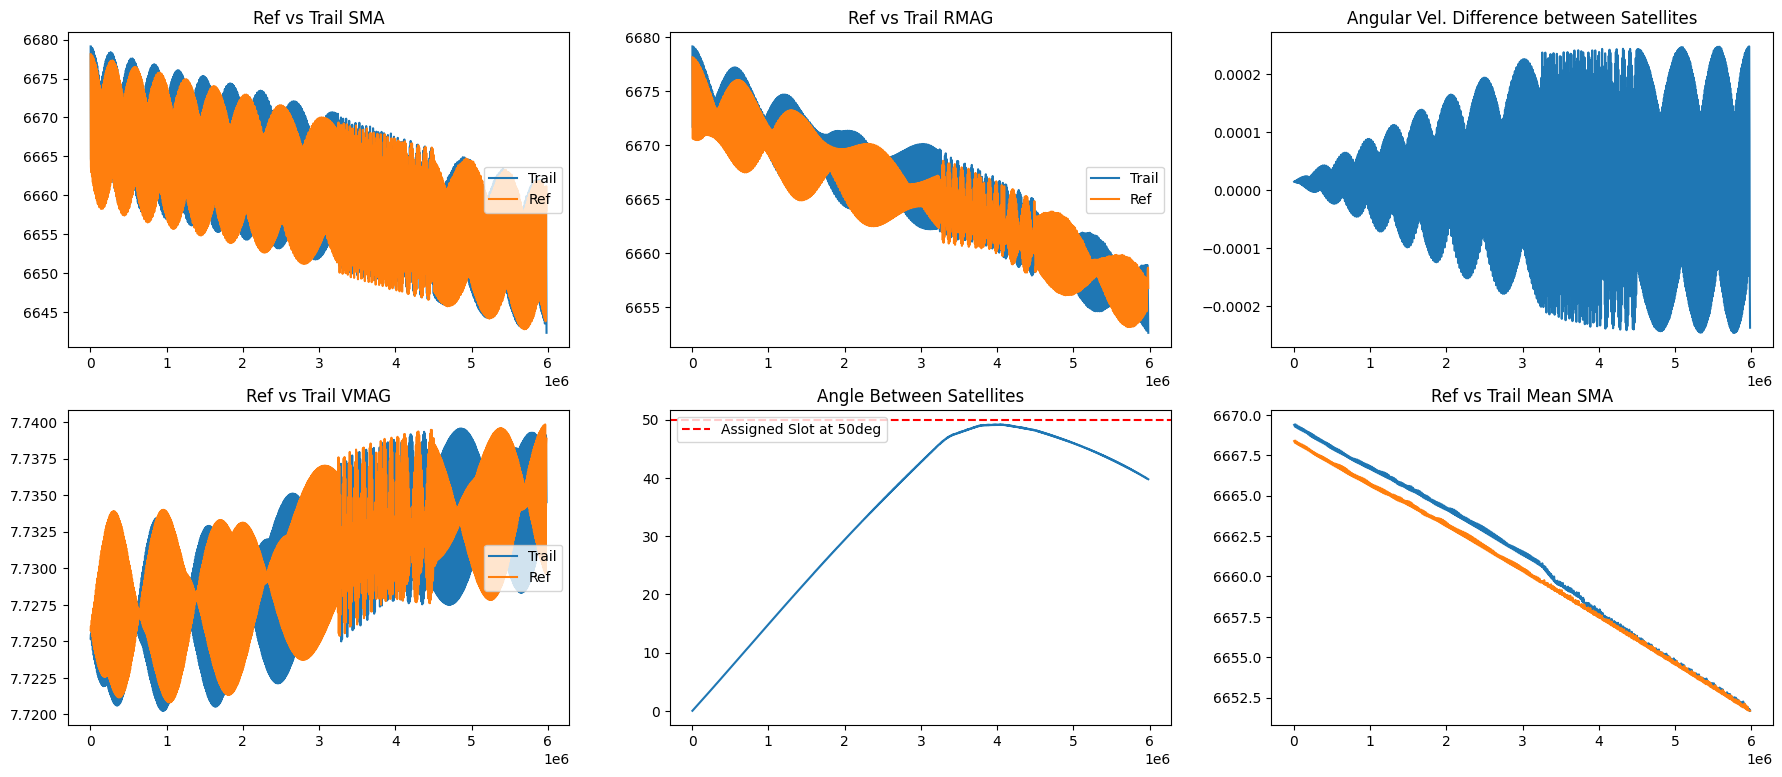

In [13]:
fig, ax = plt.subplots(2, 3, figsize=(22,9), squeeze=False) 

ax[0,0].plot(elapsedsecs,trailsmalist,label='Trail')
ax[0,0].plot(elapsedsecs,refsmalist,label='Ref')
ax[0,0].legend(loc = 'center right')
ax[0,0].set_title('Ref vs Trail SMA')

ax[0,1].plot(elapsedsecs,rmag_trail,label='Trail')
ax[0,1].plot(elapsedsecs,rmag_ref,label='Ref')
ax[0,1].legend(loc = 'center right')
ax[0,1].set_title('Ref vs Trail RMAG')

ax[1,0].plot(elapsedsecs,vmag_trail,label='Trail')
ax[1,0].plot(elapsedsecs,vmag_ref, label='Ref')
ax[1,0].legend(loc = 'center right')
ax[1,0].set_title('Ref vs Trail VMAG')

# z = np.polyfit(elapsedsecs, angle_list, 1)
# p = np.poly1d(z)

ax[1,1].plot(elapsedsecs,angle_list)
# ax[1,1].plot(elapsedsecs,p(elapsedsecs))
ax[1,1].axhline(assignment,linestyle='--',color='red',label = f'Assigned Slot at {assignment}deg')
ax[1,1].legend(loc = 'upper left')
ax[1,1].set_title('Angle Between Satellites')

ax[0,2].plot(elapsedsecs,ang_vel_list)
ax[0,2].set_title('Angular Vel. Difference between Satellites')

ax[1,2].plot(elapsedsecs,trailsmalist_mean,label='Trail')
ax[1,2].plot(elapsedsecs,refsmalist_mean,label='Ref')
ax[1,2].set_title('Ref vs Trail Mean SMA')

# plt.show(block=True)

print(f'Starting HD windows time step [s]: {hd_window}')
print(f'HD windows duration [s]: {hd_duration}')

tic = time.time()
print(f'Timestep {time_step:.4f}s')
print(f'Run time {tic-toc:.2f}s/{(tic-toc)/60:.2f}m')
plt.show()